# Pythagorean three-body problem: preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:">
             Initial value problem:</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations-(Second-Order-ODE)">
              Float64 Computations (Second Order ODE)</a></li>

<li><a href="#Float128-Computations-(General ODE Problem)">
              Float128 Computations (General ODE Problem)</a></li>

<li><a href="#Float128-Computations-(Second-Order-ODE)">
              Float128 Computations (Second Order ODE)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using Plots, LinearAlgebra
using Dates, LaTeXStrings
using JLD2, FileIO
using RecursiveArrayTools
using BenchmarkTools
using IRKGaussLegendre 

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: 

In [4]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/InitialPythagorean3BP.jl")

t0=0.0
t1=63.0

u064,Gm64 =InitialPythagorean3BP(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64)

u0128,Gm128=InitialPythagorean3BP(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[:,:,1]
v064=u064[:,:,2]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64)
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64)


q0128=u0128[:,:,1]
v0128=u0128[:,:,2]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128)
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128)


(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Float64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/pythagorean_test_sol.jld2" sol

@load "./Data/pythagorean_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialPythagorean3BP(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(63.0f0, -5.678313f-32)

<a href="#top">Back to the top</a>

## Float64 Computations (Second Order ODE)

### IRKGL16 

In [6]:
sol1 = solve(prob64,IRKGL16(second_order_ode=true), reltol=1e-12, abstol=1e-12,adaptive=true)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  70128
Number of function 2 evaluations:                  60880
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     7610
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          1027
Number of rejected steps:                          129

In [7]:
@btime solve(prob64,IRKGL16(second_order_ode=true), save_everystep=false,
             reltol=1e-12, abstol=1e-12,adaptive=true);

  19.214 ms (4598 allocations: 1.51 MiB)


### IRKGL16-SIMD

In [8]:
sol2 = solve(prob64,IRKGL16(second_order_ode=true, simd=true), reltol=1e-12, abstol=1e-12,adaptive=true)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  69800
Number of function 2 evaluations:                  60560
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     7570
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          1026
Number of rejected steps:                          129

In [9]:
@btime  solve(prob64,IRKGL16(second_order_ode=true, simd=true), save_everystep=false,
             reltol=1e-12, abstol=1e-12,adaptive=true);

  3.322 ms (4576 allocations: 1.75 MiB)


### Vern9

In [10]:
sol9 =solve(probdyn64,Vern9(), abstol=1e-12,reltol=1e-12);
sol9.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  69538
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          3726
Number of rejected steps:                          620

In [11]:
@btime solve(probdyn64,Vern9(), abstol=1e-12,reltol=1e-12,  save_everystep=false);

  17.479 ms (56699 allocations: 1.01 MiB)


### DPRK12

In [12]:
sol8 =solve(prob2nd64,DPRKN12(),abstol=1e-12,reltol=1e-12);
sol8.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  48504
Number of function 2 evaluations:                  2854
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          2301
Number of rejected steps:                          552

In [13]:
@btime solve(prob2nd64,DPRKN12(),abstol=1e-12,reltol=1e-12,  save_everystep=false);

  3.328 ms (37282 allocations: 692.33 KiB)


### Some Plots

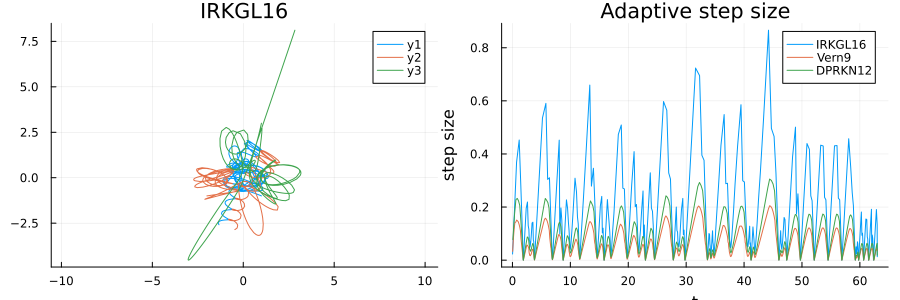

In [14]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist = sol1.u[1:end]
tlist = sol1.t[1:end]

for j = 1:3
   xlist  = map(u->u[1,j,1], ulist)     
   ylist  = map(u->u[2,j,1], ulist)   
   pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  



pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(pl2,sol1.t[2:end],steps1, label="IRKGL16")
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot!(pl2,sol9.t[2:end],steps9, label="Vern9")
steps8 =sol8.t[2:end]-sol8.t[1:end-1]
plot!(pl2,sol8.t[2:end],steps8, label="DPRKN12")

plot(pl1,pl2, layout=(1,2), size=(900,300))

### Energy Error

In [15]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialPythagorean3BP(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol2.u)./E0.-1
ΔE9 = map(x->NbodyEnergy3(BigFloat.(x),Gm256), sol9.u)./E0.-1
ΔE8 = map(x->NbodyEnergy4(BigFloat.(x),Gm256), sol8.u)./E0.-1
(Float32(maximum(abs.(ΔE1))), Float32(maximum(abs.(ΔE2))),  Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE8))))

(3.830796f-10, 3.5025835f-10, 2.1854818f-9, 2.3354194f-9)

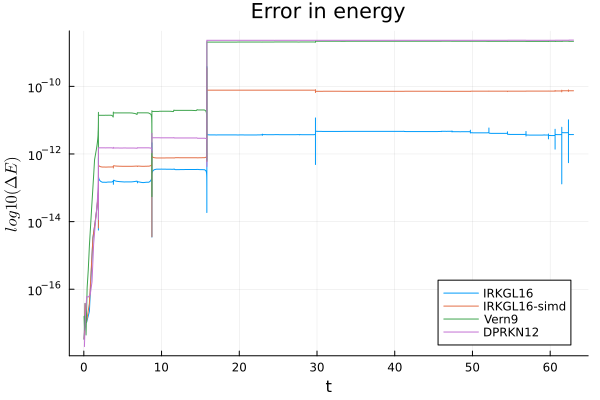

In [16]:
plot(title="Error in energy", xlabel="t", legend=:bottomright, ylabel=L"log10(\Delta E)")
plot!(sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16")
plot!(sol2.t[2:end], abs.(ΔE2[2:end]), yscale=:log10, label="IRKGL16-simd")
    
plot!(sol9.t[2:end], abs.(ΔE9[2:end]),  yscale=:log10, label="Vern9")
plot!(sol8.t[2:end], abs.(ΔE8[2:end]), yscale=:log10, label="DPRKN12")

<a href="#top">Back to the top</a>

## Float128 Computations (General ODE Problem)

In [17]:
setprecision(BigFloat, 108);

### IRKGL16 

In [18]:
sol11 = solve(prob128,IRKGL16(), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), adaptive=true)
sol11.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  403640
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     50455
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          3143
Number of rejected steps:                          262

In [19]:
@btime solve(prob128,IRKGL16(), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), 
              save_everystep=false, adaptive=true);

  8.339 s (287517490 allocations: 11.78 GiB)


### Vern9

In [20]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  445730
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          27858
Number of rejected steps:                          0

In [21]:
@btime solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20,  save_everystep=false);

  14.113 s (270279809 allocations: 10.46 GiB)


### Some Plots

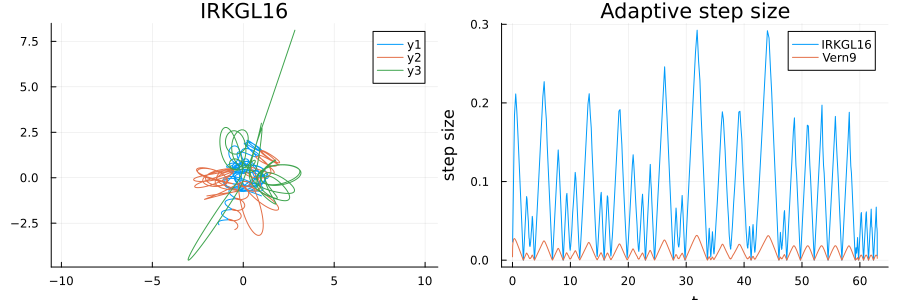

In [22]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist = sol11.u[1:end]
tlist = sol11.t[1:end]

for j = 1:3
   xlist  = map(u->u[1,j,1], ulist)     
   ylist  = map(u->u[2,j,1], ulist)   
   pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  



pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps11 =sol11.t[2:end]-sol11.t[1:end-1]
plot!(pl2,sol11.t[2:end],steps11, label="IRKGL16")
steps19 =sol19.t[2:end]-sol19.t[1:end-1]
plot!(pl2,sol19.t[2:end],steps19, label="Vern9")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>

## Float128 Computations (Second Order Problem)

In [23]:
setprecision(BigFloat, 108);

### IRKGL16 

In [24]:
sol21 = solve(prob128,IRKGL16(second_order_ode=true), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20),adaptive=true)
sol21.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  251344
Number of function 2 evaluations:                  224104
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     28013
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          3143
Number of rejected steps:                          262

In [25]:
@btime solve(prob128,IRKGL16(second_order_ode=true), reltol=BigFloat(1e-20), abstol=BigFloat(1e-20),
             save_everystep=false, adaptive=true);

  6.710 s (175032540 allocations: 7.18 GiB)


### Vern9

In [26]:
sol29 = solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20)
sol29.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  445730
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          27858
Number of rejected steps:                          0

In [29]:
@btime  solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20, save_everystep=false);

  15.310 s (275016621 allocations: 10.66 GiB)


### DPRKN12

In [28]:
sol28 = solve(prob2nd128,DPRKN12(), abstol=1e-20,reltol=1e-20);
sol28.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  187751
Number of function 2 evaluations:                  11045
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          11044
Number of rejected steps:                          0

In [30]:
@btime solve(prob2nd128,DPRKN12(), abstol=1e-20,reltol=1e-20,  save_everystep=false);

  3.090 s (80559413 allocations: 3.30 GiB)


### Some Plots

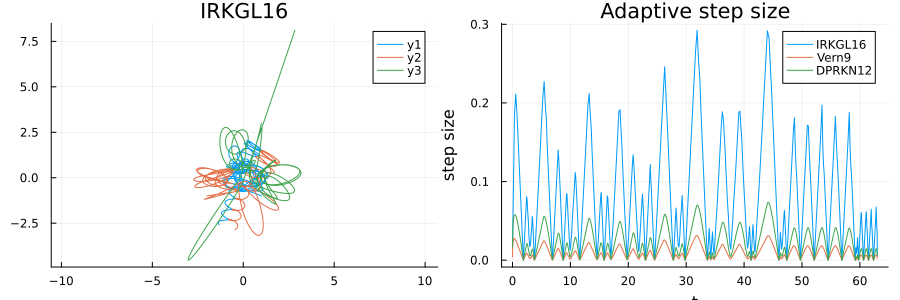

In [31]:
pl1 = plot(title="IRKGL16",aspect_ratio=1)

ulist = sol21.u[1:end]
tlist = sol21.t[1:end]

for j = 1:3
   xlist  = map(u->u[1,j,1], ulist)     
   ylist  = map(u->u[2,j,1], ulist)   
   pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end  


pl2=plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps21 =sol21.t[2:end]-sol21.t[1:end-1]
plot!(pl2,sol21.t[2:end],steps21, label="IRKGL16")
steps29 =sol29.t[2:end]-sol29.t[1:end-1]
plot!(pl2,sol29.t[2:end],steps29, label="Vern9")
steps28 =sol28.t[2:end]-sol28.t[1:end-1]
plot!(pl2,sol28.t[2:end],steps28, label="DPRKN12")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>

## Error in energy

In [33]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialPythagorean3BP(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol11.u)./E0.-1
ΔE19 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol19.u)./E0.-1
ΔE21 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol21.u)./E0.-1;
ΔE29 = map(x->NbodyEnergy3(BigFloat.(x),Gm256), sol29.u)./E0.-1;
ΔE28 = map(x->NbodyEnergy4(BigFloat.(x),Gm256), sol28.u)./E0.-1;
(Float32(maximum(abs.(ΔE11))), Float32(maximum(abs.(ΔE19))),Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE29))) , Float32(maximum(abs.(ΔE28))))

(2.0483112f-20, 3.4825425f-18, 2.0483112f-20, 3.4825425f-18, 3.476698f-21)

In [34]:
pl1=plot(title="Error in energy (General ODE Problem)", xlabel="t",
     legend=:bottomright, ylabel=L"log10(\Delta E)")
plot!(pl1, sol11.t[2:end], abs.(ΔE11[2:end]), yscale=:log10, label="IRKGL16-F128")
plot!(pl1, sol19.t[2:end], abs.(ΔE19[2:end]), yscale=:log10, label="Vern9-F128")


pl2=plot(title="Energy error (Second ODE Problem)", xlabel="t",
      legend=:bottomright, ylabel=L"log10(\Delta E)")
plot!(pl2, sol21.t[2:end],abs.(ΔE21[2:end]),  yscale=:log10, label="IRKGL16-F128")
plot!(pl2, sol29.t[2:end],abs.(ΔE29[2:end]),  yscale=:log10, label="Vern9-F128 (dynamic) ")
plot!(pl2, sol28.t[2:end],abs.(ΔE28[2:end]),  yscale=:log10,  label="DPRKN12")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>